In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

# import the relevant regressors
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

!pip install xgboost
import xgboost as xgb


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


# Read File

In [15]:
df = pd.read_csv('StudentsPerformance.csv')

# EDA

In [16]:
print(df.head())

   gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75  


# Clean the data and separate into training, validation, test tests and target output

Training / validation / test set in 60%/20%/20% ratio

In [17]:
# Check whether there is any missing data:

df.isna().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [18]:
# Split the dataset

df_all_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_all_train, test_size=0.25, random_state=42)

y_train = []
y_val = []
y_all_train = []
y_test = []

y_train.append(df_train['math score'].values)
y_val.append(df_val['math score'].values)
y_all_train.append(df_all_train['math score'].values)
y_test.append(df_test['math score'].values)

y_train.append(df_train['reading score'].values)
y_val.append(df_val['reading score'].values)
y_all_train.append(df_all_train['reading score'].values)
y_test.append(df_test['reading score'].values)

y_train.append(df_train['writing score'].values)
y_val.append(df_val['writing score'].values)
y_all_train.append(df_all_train['writing score'].values)
y_test.append(df_test['writing score'].values)

del df_train['math score']
del df_val['math score']
del df_all_train['math score']
del df_test['math score']

del df_train['reading score']
del df_val['reading score']
del df_all_train['reading score']
del df_test['reading score']

del df_train['writing score']
del df_val['writing score']
del df_all_train['writing score']
del df_test['writing score']

# Use Data Vectorizer
dv = DictVectorizer(sparse=True)

train_dict = df_train.to_dict(orient='records')
all_train_dict = df_all_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')
test_dict = df_test.to_dict(orient='records')

X_train = dv.fit_transform(train_dict)
X_all_train = dv.transform(all_train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)

# columns:
print(dv.get_feature_names_out())

['gender=female' 'gender=male' 'lunch=free/reduced' 'lunch=standard'
 "parental level of education=associate's degree"
 "parental level of education=bachelor's degree"
 'parental level of education=high school'
 "parental level of education=master's degree"
 'parental level of education=some college'
 'parental level of education=some high school' 'race/ethnicity=group A'
 'race/ethnicity=group B' 'race/ethnicity=group C'
 'race/ethnicity=group D' 'race/ethnicity=group E'
 'test preparation course=completed' 'test preparation course=none']


# Apply Different types of Regressor

- LinearRegressor
- DecisionTreeRegressor
- XGBoost

In [39]:
# Linear Regression (Lasso)

# For Math, Reading, Writing [0,1,2]:
lr = []
pred_lr = []
for i in range(3):
    lr.append(DecisionTreeRegressor())
    lr[i].fit(X_train, y_train[i])
    pred_lr.append(lr[i].predict(X_val))

In [20]:
# Decision Tree Regressor

# For Math, Reading, Writing [0,1,2]:
dt = []
pred_dt = []
for i in range(3):
    dt.append(DecisionTreeRegressor())
    dt[i].fit(X_train, y_train[i])
    pred_dt.append(dt[i].predict(X_val))

In [21]:
# Random Forest Regressor

# For Math, Reading, Writing [0,1,2]:
rf = []
pred_rf = []
for i in range(3):
    rf.append(RandomForestRegressor())
    rf[i].fit(X_train, y_train[i])
    pred_rf.append(dt[i].predict(X_val))

In [22]:
# XGBoost

etas = [0.3,0.1]
features = list(dv.get_feature_names_out())

for eta in etas:

    for i in range(3):
        
        dtrain = xgb.DMatrix(X_train, label=y_train[i], feature_names=features)
        dval = xgb.DMatrix(X_val, label=y_val[i], feature_names=features)

    
        xgb_params = {
            'eta': eta,
            'max_depth': 6,
            'min_child_weight': 1,
            
            'objective': 'reg:squarederror',
            'nthread': 8,
            
            'seed': 1,
            'verbosity': 1,
        }

        #model = xgb.train(
        #    xgb_params,
        #    dtrain,
        #    evals=watchlist,
        #    verbose_eval=0,
        #    num_boost_round=100,
        #    evals_result=evals_result
        #)

        model = xgb.train(xgb_params,dtrain=dtrain,num_boost_round=100)

        pred_xgb = model.predict(dval)
        score = np.sqrt(mean_squared_error(y_val[i], pred_xgb))

        print(f'eta:{eta}, score:%.3f' % score)
# some kind of tuning?

eta:0.3, score:15.403
eta:0.3, score:15.267
eta:0.3, score:14.540
eta:0.1, score:14.925
eta:0.1, score:14.693
eta:0.1, score:14.216


# Visualize the Results

ValueError: x and y must be the same size

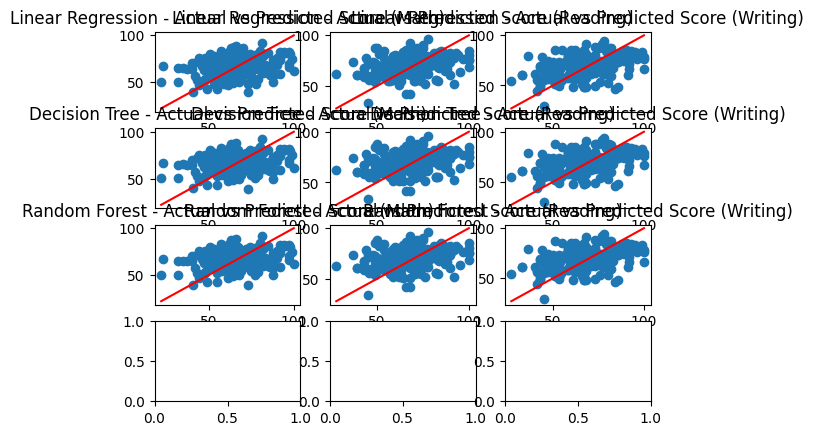

In [59]:
types = ['Math', 'Reading', 'Writing']
methods = {'lr':'Linear Regression','dt':'Decision Tree','rf':'Random Forest','xgb':'XGBoost'}

fig, ax = plt.subplots(nrows=4, ncols=3)

for index, (m,n) in enumerate(methods.items()):
    for i,name in enumerate(types):
        y_var = globals()[f'pred_{m}'][i]
        # sns.scatterplot(x=y_val[i], y=y_var)
        ax[index,i].scatter(y_val[i], y_var)
        min_val = min(y_val[i].min(), y_var.min())
        max_val = max(y_val[i].max(), y_var.max())
        x_line = np.linspace(min_val, max_val, 2)
        y_line = x_line
        ax[index,i].plot(x_line, y_line, color='red')
        #ax[index,i].xlabel('Actual Score')
        #ax[index,i].ylabel('Predicted Values')
        ax[index,i].set_title(f'{n} - Actual vs Predicted Score ({name})')

plt.show()

# Evaluation

In [ ]:
# First do tuning for parameters

In [ ]:
# Apply appropriate evaluation metrics to measure performance

#rmse = []
#rmse.append(np.sqrt(mean_squared_error(y_pred, y_val)))